## Read in the mesh

(2030, 6)
(4173, 2)
all elements have consistent orientation


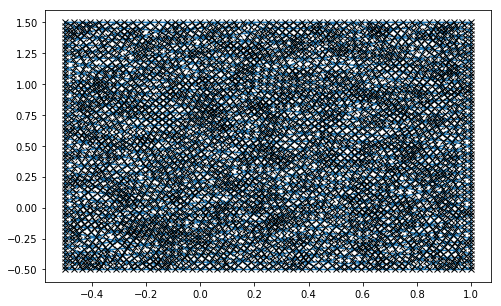

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse as sparse
import scipy.linalg as la
import scipy.sparse.linalg as sla
%matplotlib inline

import gmsh
mesh = gmsh.Mesh()
mesh.read_msh('r3.msh')

# Mesh |  ne   |  nv
#  w1  |  255  |  557
#  w2  |  1020 |  2134
#  w3  |  4080 |  8348

## Quadratic triangle elements
E = mesh.Elmts[9][1]
V = mesh.Verts[:,:2]

ne = E.shape[0]
nv = V.shape[0]
X = V[:,0]
Y = V[:,1]

print(E.shape)
print(V.shape)

def checkorientation(V, E):
    sgn = np.zeros((E.shape[0],))
    for i in range(E.shape[0]):
        xi = V[E[i, :3],0]
        yi = V[E[i, :3],1]
        A = np.zeros((3,3))
        A[:,0] = 1.0
        A[:,1] = xi
        A[:,2] = yi
        sgn[i] = np.linalg.det(A)
    return sgn

sgn = checkorientation(V, E)
I = np.where(sgn<0)[0]
if(I.size==ne or I.size==0):
    print('all elements have consistent orientation')

# plt.figure(figsize=(19,10))
plt.figure(figsize=(8,5))
plt.triplot(X,Y,E[:,:3])
plt.plot(X,Y,'kx')
# plt.tricontourf(X, Y, E[:,:3], (X-5)**2 + (Y-5)**2, 100)
# plt.colorbar()
plt.show()

In [82]:
# get first order points and their indcies.

E1,Eindex = np.unique(E[:,:3],return_index=True)


index_map = np.zeros(int(np.amax(E1)+1))
index_map[E1] = np.arange(len(E1))
index_map = index_map.astype(int)

X1 = V[E1,0]
Y1 = V[E1,1]

E2 = np.zeros(E[:,:3].shape)
for ei in range(E.shape[0]):
    E2[ei,:] = index_map[E[ei,:3]]

## Exact solution is provided here

Pressure is not defined on all of the points in V.

In [83]:
def wan_exact(): # Wannier-Stokes
    
    from sympy import symbols, exp, log, cos, sin, pi, lambdify, init_printing, diff, simplify
    x,y,k1,k2,u,v=symbols('x y k1 k2 u v')
    lambda_ = -2*pi
    # # maslanik, sani, gresho

    u = 1.0 - exp(lambda_*x)*cos(2*pi*y)
    v = lambda_/2/pi*exp(lambda_*x)*sin(2*pi*y)

    ue = lambdify([x,y],u,'numpy')
    ve = lambdify([x,y],v,'numpy')
    #pe = lambdify([x,y],p,'numpy')
    return ue,ve

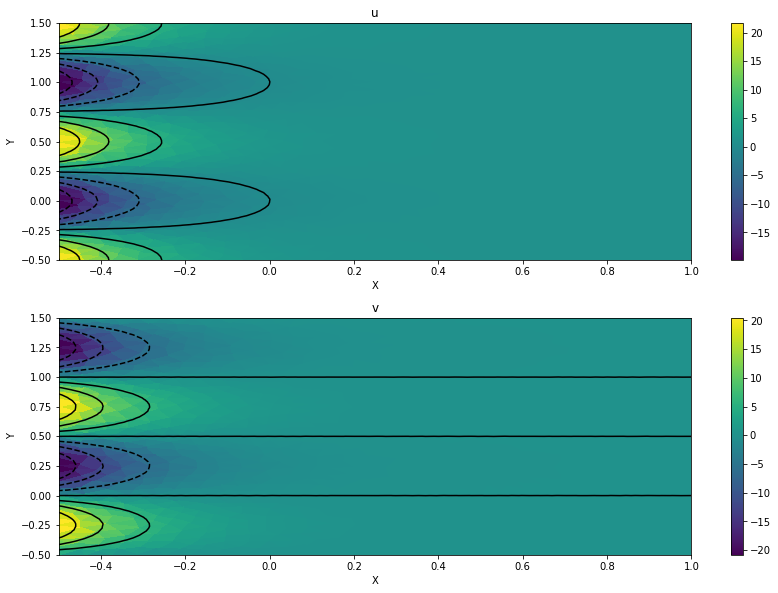

In [84]:
ue, ve = wan_exact()
uex = ue(X,Y)
vex = ve(X,Y)
#pex = pe(X1,Y1)
fig = plt.figure(figsize=(12,12))
import matplotlib.tri as tri
triang = tri.Triangulation(X,Y)
triang1 = tri.Triangulation(X1,Y1)
ax = fig.add_subplot(3,1,1)
surf = ax.tripcolor(X, Y, uex, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, uex, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,2)
surf = ax.tripcolor(X, Y, vex, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, vex, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('v')
fig.colorbar(surf)
fig.tight_layout()
#ax = fig.add_subplot(3,1,3)
#surf = ax.tripcolor(X1, Y1, pex, triangles=E2, cmap=plt.cm.viridis, linewidth=0.2)
#ax.tricontour(triang1, pe(X1,Y1),colors='k')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_title('v')
#fig.colorbar(surf)
#fig.tight_layout()


## Build your matrices

In [85]:
def trigauss(n):
    if (n == 1):
        xw=np.array([0.33333333333333, 0.33333333333333, 1.00000000000000])
    elif (n == 2):
        xw=np.array([[0.16666666666667, 0.16666666666667, 0.33333333333333],
                     [0.16666666666667, 0.66666666666667, 0.33333333333333],
                     [0.66666666666667, 0.16666666666667, 0.33333333333333]])
    elif (n == 3):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.56250000000000],
                     [0.20000000000000, 0.20000000000000, 0.52083333333333],
                     [0.20000000000000, 0.60000000000000, 0.52083333333333],
                     [0.60000000000000, 0.20000000000000, 0.52083333333333]])
    elif (n == 4):
        xw=np.array([[0.44594849091597, 0.44594849091597, 0.22338158967801],
                     [0.44594849091597, 0.10810301816807, 0.22338158967801],
                     [0.10810301816807, 0.44594849091597, 0.22338158967801],
                     [0.09157621350977, 0.09157621350977, 0.10995174365532],
                     [0.09157621350977, 0.81684757298046, 0.10995174365532],
                     [0.81684757298046, 0.09157621350977, 0.10995174365532]])
    elif (n == 5):
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.22500000000000],
                     [0.47014206410511, 0.47014206410511, 0.13239415278851],
                     [0.47014206410511, 0.05971587178977, 0.13239415278851],
                     [0.05971587178977, 0.47014206410511, 0.13239415278851],
                     [0.10128650732346, 0.10128650732346, 0.12593918054483],
                     [0.10128650732346, 0.79742698535309, 0.12593918054483],
                     [0.79742698535309, 0.10128650732346, 0.12593918054483]])
    elif (n == 6):
        xw=np.array([[0.24928674517091, 0.24928674517091, 0.11678627572638 ],
                     [0.24928674517091, 0.50142650965818, 0.11678627572638 ],
                     [0.50142650965818, 0.24928674517091, 0.11678627572638 ],
                     [0.06308901449150, 0.06308901449150, 0.05084490637021 ],
                     [0.06308901449150, 0.87382197101700, 0.05084490637021 ],
                     [0.87382197101700, 0.06308901449150, 0.05084490637021 ],
                     [0.31035245103378, 0.63650249912140, 0.08285107561837 ],
                     [0.63650249912140, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.31035245103378, 0.08285107561837 ],
                     [0.63650249912140, 0.31035245103378, 0.08285107561837 ],
                     [0.31035245103378, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.63650249912140, 0.08285107561837]])
    elif (n == 7):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.14957004446768],
                     [0.26034596607904, 0.26034596607904, 0.17561525743321 ],
                     [0.26034596607904, 0.47930806784192, 0.17561525743321 ],
                     [0.47930806784192, 0.26034596607904, 0.17561525743321 ],
                     [0.06513010290222, 0.06513010290222, 0.05334723560884 ],
                     [0.06513010290222, 0.86973979419557, 0.05334723560884 ],
                     [0.86973979419557, 0.06513010290222, 0.05334723560884 ],
                     [0.31286549600487, 0.63844418856981, 0.07711376089026 ],
                     [0.63844418856981, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.31286549600487, 0.07711376089026 ],
                     [0.63844418856981, 0.31286549600487, 0.07711376089026 ],
                     [0.31286549600487, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.63844418856981, 0.07711376089026]])
    elif (n >= 8):
        if(n>8):
            print('trigauss: Too high, taking n = 8')
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.14431560767779],
                     [0.45929258829272, 0.45929258829272, 0.09509163426728],
                     [0.45929258829272, 0.08141482341455, 0.09509163426728],
                     [0.08141482341455, 0.45929258829272, 0.09509163426728],
                     [0.17056930775176, 0.17056930775176, 0.10321737053472],
                     [0.17056930775176, 0.65886138449648, 0.10321737053472],
                     [0.65886138449648, 0.17056930775176, 0.10321737053472],
                     [0.05054722831703, 0.05054722831703, 0.03245849762320],
                     [0.05054722831703, 0.89890554336594, 0.03245849762320],
                     [0.89890554336594, 0.05054722831703, 0.03245849762320],
                     [0.26311282963464, 0.72849239295540, 0.02723031417443],
                     [0.72849239295540, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.26311282963464, 0.02723031417443],
                     [0.72849239295540, 0.26311282963464, 0.02723031417443],
                     [0.26311282963464, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.72849239295540, 0.02723031417443]])

    qx = xw[:,:2]
    qw = xw[:,2]/2
    return qx, qw

In [86]:
def p1(r,s):
    return (1-r-s)*(1-2*r-2*s)
def p2(r,s):
    return (-r)*(1-2*r)
def p3(r,s):
    return (-s)*(1-2*s)
def p4(r,s):
    return 4*r*(1-r-s)
def p5(r,s):
    return 4*r*s
def p6(r,s):
    return 4*s*(1-r-s)

def dp1_dr(r,s):
    return -1.0+2.0*r-2.0*(1.0-r-s)+2.0*s
def dp1_ds(r,s):
    return -1.0+2.0*r-2.0*(1.0-r-s)+2.0*s
def dp2_dr(r,s):
    return -1.0+4.0*r
def dp2_ds(r,s):
    return 0.0
def dp3_dr(r,s):
    return 0.0
def dp3_ds(r,s):
    return -1.0+4.0*s
def dp4_dr(r,s):
    return -4.0*r+4.0*(1-r-s)
def dp4_ds(r,s):
    return -4.0*r
def dp5_dr(r,s):
    return 4.0*s
def dp5_ds(r,s):
    return 4.0*r
def dp6_dr(r,s):
    return -4.0*s
def dp6_ds(r,s):
    return 4.0*(1.0-r-s)-4.0*s
def dp_matrix(r,s):
    matrix = [\
             [dp1_dr(r,s), dp1_ds(r,s)],[dp2_dr(r,s), dp2_ds(r,s)],\
             [dp3_dr(r,s), dp3_ds(r,s)],[dp4_dr(r,s), dp4_ds(r,s)],\
             [dp5_dr(r,s), dp5_ds(r,s)],[dp6_dr(r,s), dp6_ds(r,s)]]
    return np.array(matrix)
def p_matrix(r,s):
    matrix = [p1(r,s),p2(r,s),p3(r,s),p4(r,s),p5(r,s),p6(r,s)]
    return np.array(matrix)

def ps1(r,s):
    return 1.0-r-s
def ps2(r,s):
    return r
def ps3(r,s):
    return s
def ps_matrix(r,s):
    matrix = [ps1(r,s),ps2(r,s),ps3(r,s)]
    return np.array(matrix)


In [87]:
l_solver = la.inv([\
                   [1,0,0,0,0,0],\
                   [1,1,0,0,1,0],\
                   [1,0,1,0,0,1],\
                   [1,0.5,0,0,0.25,0],\
                   [1,0.5,0.5,0.25,0.25,0.25],\
                   [1,0,0.5,0,0,0.25]])

def l_coeff(vs):
    # vs are vertices of the element and has shape = (6,2)
    return l_solver.dot(vs)

def J_J_inv_J_det(r,s,coeff):
    
    J = np.zeros((2,2))
    J[:,0] = coeff[1] + coeff[3]*s + 2.0*r*coeff[4]
    J[:,1] = coeff[2] + coeff[3]*r + 2.0*s*coeff[5]
    J_det = la.det(J)
    J_inv = la.inv(J)
    return J,J_inv,J_det

def J_det_func(r,s,coeff):
    J = np.zeros((2,2))
    J[:,0] = coeff[1] + coeff[3]*s + 2.0*r*coeff[4]
    J[:,1] = coeff[2] + coeff[3]*r + 2.0*s*coeff[5]
    J_det = la.det(J)
    return J_det

def one_element(ei):
    K = E[ei]
    vs = V[K]
    
    coeff = l_coeff(vs)
    
    qx,qw = trigauss(4) 
    n = len(qw)
    Aelem = 0.0
    for i in range(n):
        r,s = qx[i]
        w = qw[i]
        J, J_inv, J_det = J_J_inv_J_det(r,s,coeff)
        dphi = dp_matrix(r,s).dot(J_inv)
        Aelem += dphi.dot(dphi.transpose())*J_det*w
    qx,qw = trigauss(6) 
    n = len(qw)
    Dxelem = 0.0
    Dyelem = 0.0
    for i in range(n):
        r,s = qx[i]
        w = qw[i]
        J,J_inv,J_det = J_J_inv_J_det(r,s,coeff)
        dphi = dp_matrix(r,s).dot(J_inv)
        Dxelem+=np.outer(ps_matrix(r,s),dphi[:,0])*J_det*w
        Dyelem+=np.outer(ps_matrix(r,s),dphi[:,1])*J_det*w
    return Aelem,Dxelem,Dyelem,K


In [88]:
AA = np.zeros((ne, 36))
IA = np.zeros((ne, 36))
JA = np.zeros((ne, 36))

Dx_= np.zeros((ne, 18))
Dy_= np.zeros((ne, 18))
iD = np.zeros((ne, 18))
jD = np.zeros((ne, 18))
for ei in range(ne):
    Aelem,Dxelem,Dyelem,K = one_element(ei)
    KK = np.tile(K,(6,1))
    AA[ei,:] = Aelem.ravel()
    IA[ei,:] = KK.flatten(order='F')
    JA[ei,:] = KK.flatten()
    Dx_[ei,:] = Dxelem.ravel()
    Dy_[ei,:] = Dyelem.ravel()
    iD[ei,:] = index_map[ KK[:,:3].flatten(order='F') ]
    jD[ei,:] = KK.flatten()[:18] 
Abar = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
Abar = Abar.tocsr()
Abar = Abar.tocoo()
Dx = sparse.coo_matrix((Dx_.ravel(), (iD.ravel(), jD.ravel())))
Dy = sparse.coo_matrix((Dy_.ravel(), (iD.ravel(), jD.ravel())))
Dx = Dx.tocsr()
Dx = Dx.tocoo()
Dy = Dy.tocsr()
Dy = Dy.tocoo()


## Apply boundary conditions

There are two sets of Dirichlet boundaries:

 - the cylinder surface
 - the rectangle sides

In [89]:
# Locations of the Wannier boundary 
tol = 1.e-12
tol2 = 1.e-6
#Dflag1 = np.array((abs(np.power(X,2.)+np.power(Y-2.,2.)-1.) < tol))
Dflag = np.logical_or.reduce((abs(X+0.5 ) < tol2,
                               abs(X-1.0) < tol2,
                               abs(Y+0.5)  < tol2,
                               abs(Y-1.5) < tol2))

ID = np.where(Dflag)[0]
IDc = np.where(Dflag==False)[0]
print(ID.size,IDc.size)

224 3949


In [90]:
freenv = IDc.size
R = sparse.coo_matrix((np.ones(freenv),(np.arange(freenv), IDc )))
R = R.tocsr()
R = R.tocoo()
R_trans = R.transpose()

ux = np.zeros(nv)
uy = np.zeros(nv)
ux[ID] = uex[ID]
uy[ID] = vex[ID]


A = (R.dot(Abar)).dot(R_trans)
A = A.tocsc()
A_inv = sla.inv(A)
DxR = Dx.dot(R_trans)
DyR = Dy.dot(R_trans)

Sx = -Dx.dot(R_trans).dot(A_inv).dot(R).dot(Dx.transpose())
Sy = -Dy.dot(R_trans).dot(A_inv).dot(R).dot(Dy.transpose())

S = Sx + Sy

gp = Dx.dot(ux) + Dy.dot(uy)
fu = -Abar.dot(ux)
fv = -Abar.dot(uy)
fp = gp + Dx.dot(R_trans.dot(A_inv).dot(R.dot(fu))) + Dy.dot(R_trans.dot(A_inv).dot(R.dot(fv)))
#print (sla.eigs(S,k=1,which='SM'))

#p = sla.cg(S.tocsc(),fp)[0]

p = np.linalg.pinv(S.toarray()).dot(fp)
#p = pe(X1,Y1)
u = R_trans.dot(A_inv.dot(R.dot(fu)+R.dot(Dx.transpose().dot(p)))) + ux
v = R_trans.dot(A_inv.dot(R.dot(fv)+R.dot(Dy.transpose().dot(p)))) + uy


## Post-processing

Plot solution, find convergence rate, etc.

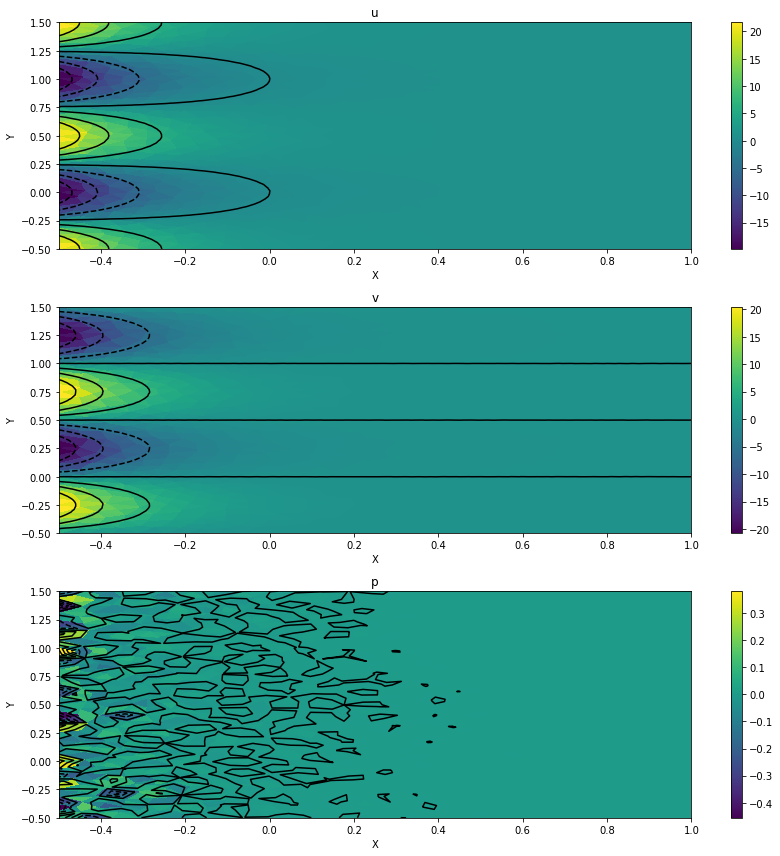

In [95]:
fig = plt.figure(figsize=(12,12))
triang = tri.Triangulation(X,Y)
triang1= tri.Triangulation(X1,Y1)
ax = fig.add_subplot(3,1,1)
surf = ax.tripcolor(X, Y, u, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, u, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,2)
surf = ax.tripcolor(X, Y, v, triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang, v, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('v')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(3,1,3)
surf = ax.tripcolor(X1, Y1, p,triangles=E2, cmap=plt.cm.viridis, linewidth=0.2)
ax.tricontour(triang1, p, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('p')
fig.colorbar(surf)
fig.tight_layout()
plt.savefig("profile_2.png")


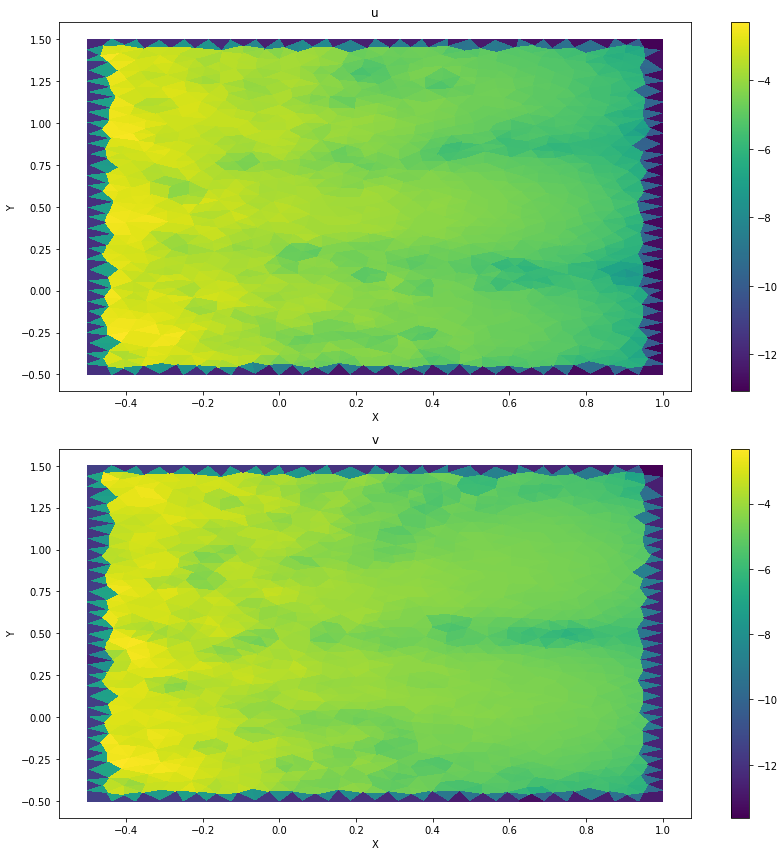

In [97]:
fig = plt.figure(figsize=(12,12))
triang = tri.Triangulation(X,Y)
triang1= tri.Triangulation(X1,Y1)
ax = fig.add_subplot(2,1,1)
surf = ax.tripcolor(X, Y, np.log10(np.abs(u-uex)+1.0e-16), triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
#ax.tricontour(triang, u, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('u')
fig.colorbar(surf)
fig.tight_layout()
ax = fig.add_subplot(2,1,2)
surf = ax.tripcolor(X, Y, np.log10(np.abs(v-vex)+1.0e-16), triangles=E[:,:3], cmap=plt.cm.viridis, linewidth=0.2)
#ax.tricontour(triang, v, colors='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('v')
fig.colorbar(surf)
fig.tight_layout()
plt.savefig("error_2.png")


In [93]:
print (Dx.shape)

(1072, 4173)


In [78]:
def trans(r,s, coefficient):
    x,y = np.array([1.0, r, s, s*r,r*r,s*s ]).dot(coefficient)
    return x, y
def err(u,ue,u_order=2):
    error = 0.0
    for ei in range(ne):
        K = E[ei]
        vs = V[K]
        if u_order==1:
            K = index_map[K[:3]]
        coeff = l_coeff(vs)
        u_elem_coeff = u[K]
        qx,qw = trigauss(8) 
        n = len(qw)
        err_elem = 0
        for i in range(n):
            r,s = qx[i]
            w = qw[i]
            J_det = J_det_func(r,s,coeff)
            if u_order==2:
                uelem = p_matrix(r,s).dot(u_elem_coeff)
            elif u_order ==1:
                uelem = ps_matrix(r,s).dot(u_elem_coeff)
            x,y = trans(r,s,coeff)
            err_elem+= (uelem - ue(x,y))**2*J_det*w
        error+=err_elem
    return error


In [79]:
u_err = err(u,ue)
v_err = err(v,ve)
#p_err = err(p,pe,u_order =1)

In [80]:
print (u_err,v_err)
#print (p_err)

0.06261183448303093 0.05318555331967135


In [25]:
from scipy.interpolate import LinearNDInterpolator
psol = LinearNDInterpolator(np.vstack([X1,Y1]).transpose(),p)

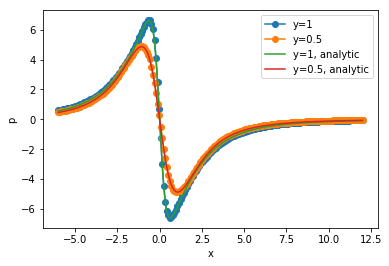

In [33]:

xarray = np.linspace(-6,12,200)
yarray = np.ones(200)
plt.plot(xarray, psol(np.vstack([xarray,yarray]).transpose() ), 'o-',label="y=1")
plt.plot(xarray, psol(np.vstack([xarray,0.5*yarray]).transpose() ),'o-', label="y=0.5")
plt.plot(xarray, pe(xarray,yarray), label="y=1, analytic")
plt.plot(xarray, pe(xarray,0.5*yarray ), label="y=0.5, analytic")
plt.legend(loc="best")
plt.ylabel("p")
plt.xlabel("x")
plt.show()